Разработать модель машинного обучения, способный классифицировать статьи на реальные и фейковые.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn import metrics

In [25]:
!git clone https://github.com/klyambda/fake-news.git

fatal: destination path 'fake-news' already exists and is not an empty directory.


### Импортируем датасет и посмотрим на наши данные.

In [26]:
train = pd.read_csv('fake-news/dataset/train.csv')
test = pd.read_csv('fake-news/dataset/test.csv')
submit = pd.read_csv('fake-news/dataset/submit.csv')

print('train dataset shape: {}'.format(train.shape))
print('test dataset shape: {}'.format(test.shape))
print('submit shape: {}'.format(submit.shape))

train dataset shape: (20800, 5)
test dataset shape: (5200, 4)
submit shape: (5200, 2)


In [27]:
train.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [28]:
train.tail(5)

,id,title,author,text,label
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1
20799,20799,What Keeps the F-35 Alive,David Swanson,"David Swanson is an author, activist, journa...",1


In [29]:
# проверяем есть ли пропущенные значения в некоторых ячейках
print(train.isna().sum())
print()
print(test.isna().sum())

id           0
title      558
author    1957
text        39
label        0
dtype: int64

id          0
title     122
author    503
text        7
dtype: int64


In [30]:
# заполняем пропущенные значения пустыми строками
train = train.fillna('')
test = test.fillna('')

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20800 non-null  object
 2   author  20800 non-null  object
 3   text    20800 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [32]:
# проверка на наличие дубликатов
print('train: ', train.duplicated().sum())
print('test: ', test.duplicated().sum())

train:  0
test:  0


Распределение по классам на реальные и фейковые статьи сбалансировано.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


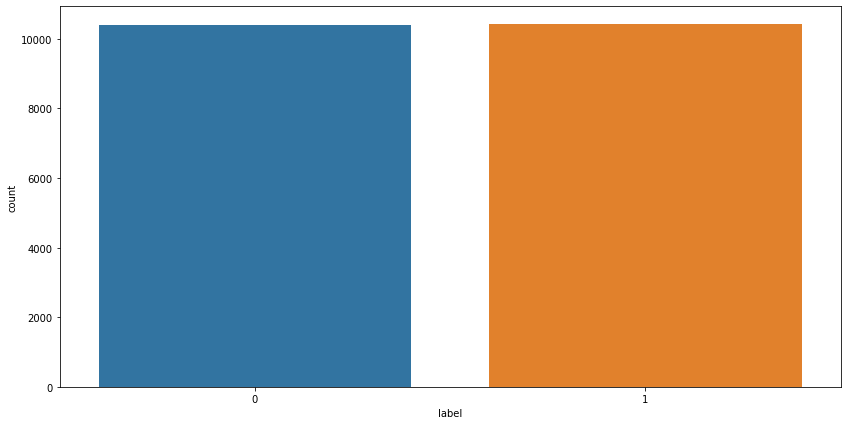

In [33]:
plt.figure(figsize=(14, 7))
sns.countplot(train['label'])

In [35]:
# Создаем новый столбец content путем объединения столбцов title и author
train['total'] = train['title'] + ' ' + train['author']
test['total'] = test['title'] + ' ' + test['author']

### Предобработка текста

Перед тем, как обучить нашу модель машинного обучения, необходимо провести предообработку текста.

In [36]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

nltk.download('stopwords')
stopwords_en = stopwords.words('english')
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
def preprocess_text(text):
    """Предобработка текста.
    
    Убирает пунктуационные символы, приводит к нижнему регистру, 
    разбивает предложение по словам, убирает стопслова, 
    проводит стемминг для каждого слова
    """
    clean_text = re.sub('[^a-zA-Z]', ' ', text)
    clean_text = clean_text.lower()
    clean_text = clean_text.split()
    clean_text = [ps.stem(word) for word in clean_text if not word in stopwords_en]
    clean_text = ' '.join(clean_text)

    return clean_text


train['total'] = train['total'].apply(preprocess_text)
test['total'] = test['total'].apply(preprocess_text)

In [38]:
train['total']

0        hous dem aid even see comey letter jason chaff...
1        flynn hillari clinton big woman campu breitbar...
2                   truth might get fire consortiumnew com
3        civilian kill singl us airstrik identifi jessi...
4        iranian woman jail fiction unpublish stori wom...
                               ...                        
20795    rapper trump poster child white supremaci jero...
20796    n f l playoff schedul matchup odd new york tim...
20797    maci said receiv takeov approach hudson bay ne...
20798    nato russia hold parallel exercis balkan alex ...
20799                            keep f aliv david swanson
Name: total, Length: 20800, dtype: object

In [39]:
# разделим тренировочный датасет на признаки и метки 
X = train['total'].values
y = train['label'].values

### Обработка текста.
После того, как мы получили в прошлом шаге чистые данные, проведем обработку данных, выбрав подходящее представление данных. 

In [40]:
# создадим общий корпус из тренировочного и тестового датасетов
# corpus = np.concatenate((X_train, X_test))
# print('corpus shape: {}'.format(corpus.shape))

Приведем наш корпус в векторное представление, используя one-hot encoding. Построим словарь для всего корпуса и каждому предложению будем отображать одномерный массив длиной размера словаря. Этот массив будет содержать количество вхождений слова в предложении. Эта модель называется "Мешком слов" (Bag of Words).

In [42]:
# определим словарь и длины предложений
VOCAB = set()
sentence_lengths = []
for sentence in X:
    sentence_lengths.append(len(sentence))
    for word in sentence.split():
        VOCAB.add(word)
print('Размер словаря: {}'.format(len(VOCAB)))
print('Максимальная длина предложения: {}'.format(max(sentence_lengths)))

Размер словаря: 17146
Максимальная длина предложения: 330


Text(0, 0.5, 'Количество предложений')

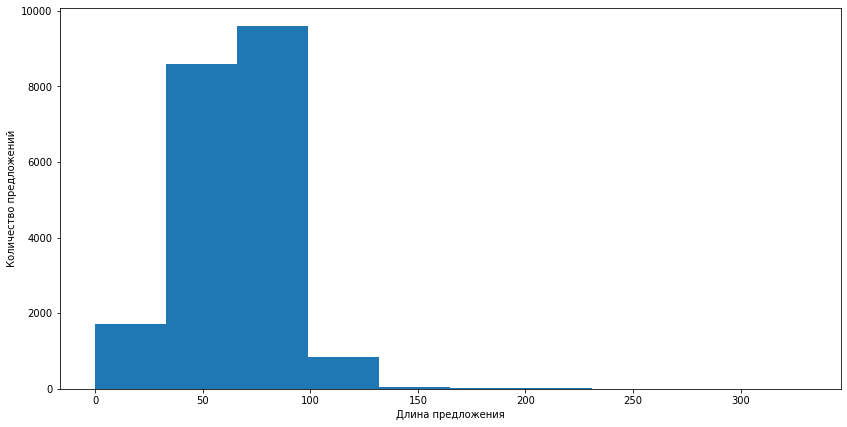

In [43]:
plt.figure(figsize=(14, 7))
plt.hist(sentence_lengths)
plt.xlabel('Длина предложения')
plt.ylabel('Количество предложений')

Максимальная длина предложения равна 330 и большинство предложений состоят из 40-100 слов, а размер словаря составляет 17146 слов. Получается что для каждого предложения соответствующий массив будет преимущественно состоять из нулей, поэтому используются разреженные матрицы (sparse matrix), состоящие из индексов матрицы и значений в этих индексах.


In [44]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
# стоим разреженную матрицу BoW для всего корпуса размером
# (кол-во_предложений, размер_словаря)

X_count = count_vectorizer.fit_transform(X)

In [45]:
X_count

<20800x17128 sparse matrix of type '<class 'numpy.int64'>'
	with 210687 stored elements in Compressed Sparse Row format>

Визуализируем векторные представления, чтобы посмотреть, насколько хорошо видны отличия между классами. Для визуализации используем метод главных компонент PCA.

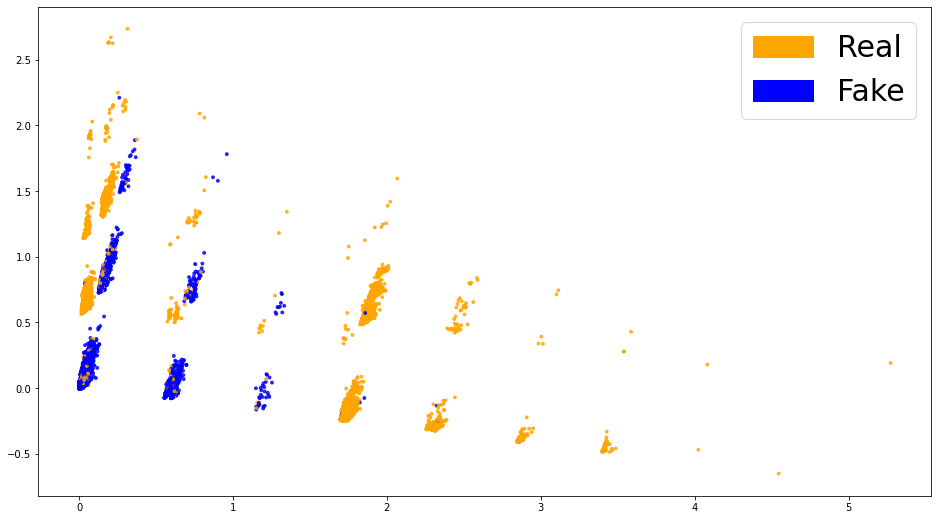

In [47]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Real')
            green_patch = mpatches.Patch(color='blue', label='Fake')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 9))          
plot_LSA(X_count, y)
plt.show()

Из графика видно, что часть реальных новостей могут быть классифицированы как фейковые. Это может отражать реальную картину или может быть связано с уменьшением размерности с помощью PCA.

In [51]:
# разделяем на тренировочный и тестовый датасет
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.25, 
                                                    random_state=42)

### Создание модели

Для начала создаем модель логистической регрессии, так как для бинарной классификации данная модель легко обучается и является простой в интерпретации результатов.

In [58]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [55]:
lg_model = LogisticRegression(random_state=42)
lg_model.fit(X_train_count, y_train)

LogisticRegression(random_state=42)

In [ ]:
# рассмотрим следующие метрики:
# precision, recall, accuracy, f1
def get_metrics(y_test, y_predict):

    precision = sum
    recall = 
    accuracy = abs(sum(y_test - y_predict)) / len(y_test)
    f1 = 

In [60]:
X_test_count_predict = lg_model.predict(X_test_count)

print('Accuracy on test set: {:.4f}%'.format(accuracy_score(X_test_count_predict, y_test) * 100))

Accuracy on test set: 98.7500%


In [61]:
X_train_count_predict = lg_model.predict(X_train_count)

print('Accuracy on train set: {:.4f}%'.format(accuracy_score(X_train_count_predict, y_train) * 100))

Accuracy on train set: 99.8910%


Посмотрим, какие именно ошибки совершает наша модель. Для этого построим матрицу ошибок (confusion matrix), которая показывает для бинарной классификации
ложно-положительные и ложно-отрицательные ошибки модели. С помощью матрицы можно понять, сможем ли мы проигнорировать данные ошибки в соответсвии поставленным приоритетам.

Для модели логистической регрессии получили точность 98.75%, что уже неплохо, но для полноты эксперимента рассмотрим другие модели машинного обучения.

In [ ]:
nb_model = 

 Поверх Bag of Words будем использовать TF-IDF (Term Frequency, Inverse Document Frequency). После того, как мы сформировали словарь и построили эмбеддинги для каждого предложения, мы понимаем, что некоторые слова встречаются практически в каждом предложении, тем самым, добавляя шум. Поэтому следует различать слова по их вкладу в информационную ценность предложения. Поэтому поверх нашего мешка слов добавим механизм TF-IDF (Term Frequency – Inverse Document Frequency). Этот механизм определяет количество вхождений слова в заданном корпусе и нормализует частоту лексем с учетом содержимого в остальном корпусе. Скоринг TF-IDF растет пропорционально частоте появления слова в корпусе, но это компенсируется количеством документов, содержащих это слово. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer()
tfidf.fit(corpus)

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
X_train_tfidf

In [ ]:
X_test_tfidf

In [ ]:
fig = plt.figure(figsize=(16, 9))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

from sklearn.linear_model import LogisticRegression
doc_clf = LogisticRegression(solver = 'lbfgs', 
                             max_iter = 500, multi_class = 'auto')
%time doc_clf.fit(x_train, y_train)
score_test = doc_clf.score(x_test, y_test)
print('Оценка точности классификации: {}%'.format(round(score_test * 100, 4)))

score_train = doc_clf.score(x_train, y_train)
print('Точность классификации на тренировочном множестве: {}%'.format(round(score_train * 100, 4)))

from sklearn.metrics import classification_report

predict = doc_clf.predict(x_test)
print(classification_report(y_test, predict, digits=4))

In [ ]:
nb_classifier = MultinomialNB(alpha=0.1)
nb_classifier.fit(X_train_vect, y_train)
nb_predict = nb_classifier.predict(X_test)
nb_acc = metrics.accuracy_score(y_test, nb_predict)
print('Точность Naive Bayes: {:.4f}'.format(nb_acc))